#### 15-7. keras-ocr 써보기

keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줍니다. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용합니다.

1) keras-ocr 설치하기

In [1]:
# !pip list | grep keras-ocr
# !pip install keras-ocr 

In [2]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [3]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

keras-ocr
https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/pipeline.py

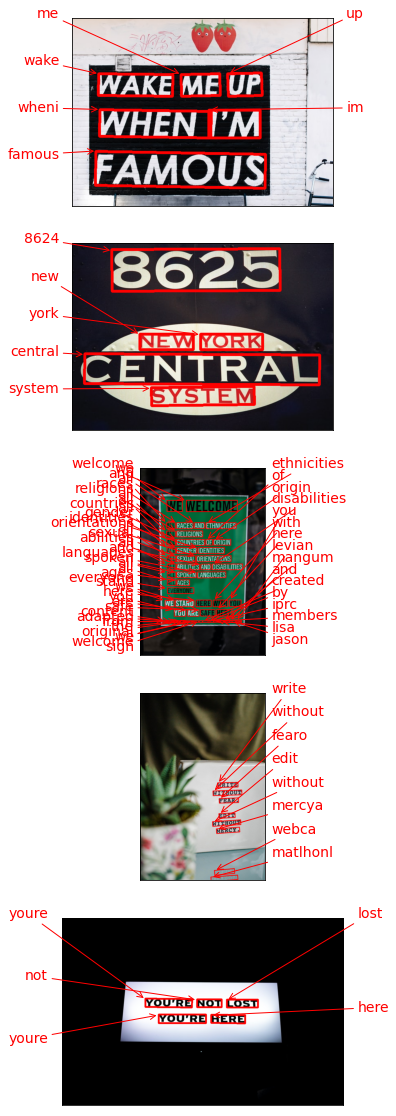

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

korean language support
https://github.com/faustomorales/keras-ocr/issues/101

#### 15-8. 테서랙트 써보기

테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용되고 있습니다. 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원하고 있습니다.

1) 테서랙트 설치하기

In [5]:
# !sudo apt install tesseract-ocr
# !sudo apt install libtesseract-dev

2) 테서랙트 파이썬 wrapper 설치하기

In [6]:
# !pip list | grep pytesseract
# !pip install pytesseract

3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [29]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

directory = os.getenv('HOME')+'/aiffel/ocr_python'
work_dir = directory+'/output'
# img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
img_file_path = directory + '/images/10.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

# cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

(주의) 위 코드에서 lang='kor' 로 바꾸면 에러가 발생합니다. 테서랙트의 언어팩을 설치해야 정상 동작하게 됩니다. 언어팩 설치

[핀란드 헤이키 (daum.net)](https://blog.daum.net/rayolla/1141)

In [31]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'], end='')
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

—
Done


#### 15-9. 프로젝트 : 다양한 OCR모델 비교하기

In [11]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


### Step1. 검증용 데이터셋 준비
  
Google OCR API, keras-ocr, Tesseract   
  
텍스트의 모양과 크기, 배치, 노이즈 등을 고려해서  문자를 detect하고 recognize 잘하는지를 검증하기 위한 이미지 데이터를 모아라.  
  
테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.


In [57]:
directory = os.getenv('HOME')+'/aiffel/ocr_python' # 20장의 화일이 준비되어있음.
work_dir = directory+'/output'

### Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)   
위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

In [56]:
def keras_output(image_urls): # OCR 패키지 비교를 위해서 이미지 한장만 출력
    images = [ keras_ocr.tools.read(url) for url in image_urls]
    prediction_groups = [pipeline.recognize([url]) for url in image_urls]
    fig, axs = plt.subplots(1,1, figsize=(5, 5))
    keras_ocr.tools.drawAnnotations(image=images[0], 
                                    predictions=prediction_groups[0][0], ax=axs)

In [ ]:
def Tesseract_output(img_file_path, work_dir):
    cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
    recognize_images(cropped_image_path_list)

###  안내판 테스트  

#### 테서렉트를 사용한 결과물이 케라스 결과물보다  먼저 문자로 출력된다.  

#### 케라스의 결과물은 사진에 주석을 달듯 보기편하게 표시되었다.


—
ret ;
Sports
ari
oy
=
Definitions
a
ss Si
Cm
:
Activity
ore
=)
———=———
Done


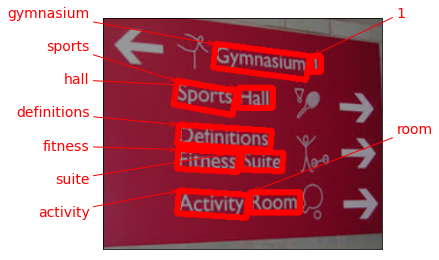

In [60]:
image_urls = ['/aiffel/aiffel/ocr_python/images/1.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

#### 큰 글씨와 작은 글씨의 혼합

POSTED
WARNING
ri
IER
ACTICE
oo
ee
VITY.
i os
ae
CHAT E.
A,
L IVIL
he
ANI)
wre Vibe ti”
EEO OE>E—Elté‘i
TN
L\CeRE POL RISA
Pil
}
\
kil
INI ik }
1G)
6)*.
ave
ACsie) PCOLIKIS VI
Ai Pig Pea NT
mi‘
BNO hY
Ay
ACF RITDOURISM
Gana
2,
TEXAS
WILDLIFE
ASSUCLCIATLION
i
EE
Done


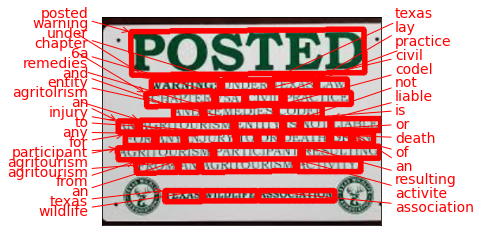

In [61]:
image_urls = ['/aiffel/aiffel/ocr_python/images/2.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)


#### 약간 옆에서 본 표지판

cose Mill 2'2
Mill
ramous
Rlacksmitns
Shop
Attractions
To
tlelal
at Gretna
feir-t-ts
= —
—“
Done


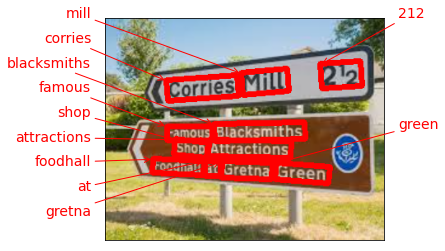

In [63]:
image_urls = ['/aiffel/aiffel/ocr_python/images/6.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

#### 사람도 읽기 힘든 길 안내

Done


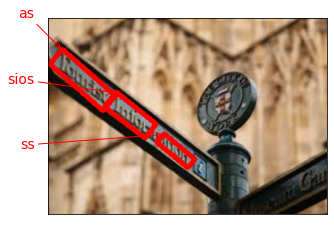

In [64]:
image_urls = ['/aiffel/aiffel/ocr_python/images/7.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

#### 반사광이 존재하는 길안내판

Done


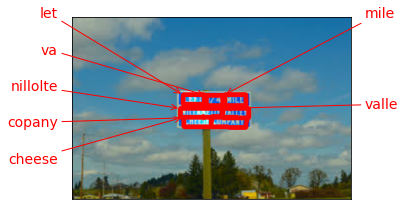

In [65]:
image_urls = ['/aiffel/aiffel/ocr_python/images/9.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

#### 풍경에 비슷한 색을 가진 표지판

Done


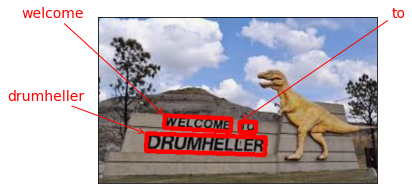

In [66]:
image_urls = ['/aiffel/aiffel/ocr_python/images/10.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

####  그림표시와 함께 다양한 크기의 폰트가 사용된 표지판

ARASTA
&
SHOPPING
CENTER
MOSAIC
MUSEUW
| tot |
<A
WC
|
errr me
‘rr iti EE OCC—<“‘é*§O:O#+;™W. eg ss ===
Done


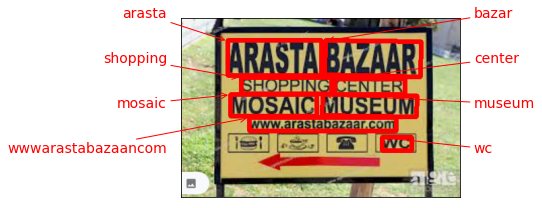

In [67]:
image_urls = ['/aiffel/aiffel/ocr_python/images/11.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

#### 그림과 함께 다양한 폰트와 크기로 쓰여진 표지판

: |
Done


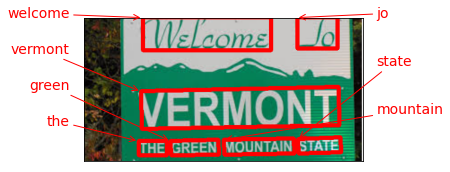

In [68]:
image_urls = ['/aiffel/aiffel/ocr_python/images/15.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

#### 희미한 글씨의 표지판

Visitors
ELEN
Done


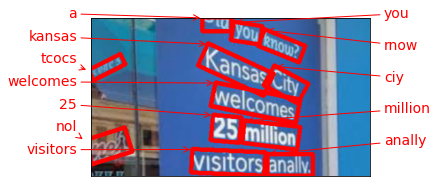

In [69]:
image_urls = ['/aiffel/aiffel/ocr_python/images/16.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

#### 다양한 폰트를 사용한 낡은 표지판

rf
1.
Done


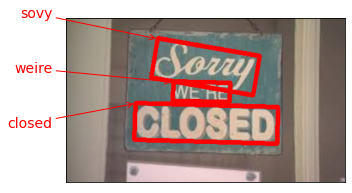

In [70]:
image_urls = ['/aiffel/aiffel/ocr_python/images/17.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

#### 독특한 폰트의 표지판

ARTEA
a
pe
-
7
ave
Done


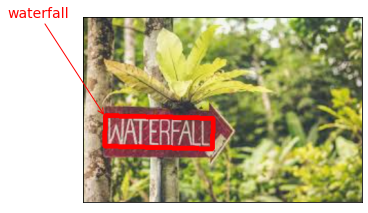

In [71]:
image_urls = ['/aiffel/aiffel/ocr_python/images/18.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

####  반사광에 가려진 글씨가 있는 다양한 폰트를 사용한 표지판

Nita
Done


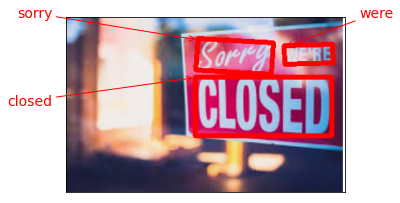

In [72]:
image_urls = ['/aiffel/aiffel/ocr_python/images/20.png']
Tesseract_output(image_urls[0], work_dir) 
keras_output(image_urls)

### Step3. 테스트 결과 정리  
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

#### Tesseract는 'Done'만 출력하는 인식하지 못하는 표지판이 많았다.

#### keras쪽이 사진 어느 곳에 무슨 문자가 있는지 확실하게 표시해줘서  사용자의 편의성이 좋았다.

### Step4. 결과 분석과 결론 제시  
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

#### 영어를 모르는 여행객들이 길거리에서 볼 수 있는 표지판을 영문으로 인식해서 검색이 쉽도록 하는 서비스를 생각해 보았다.  

#### 길거리에서 일어날 수 있는 다양한 경우의 사진을 준비하여 테스트하였고 결과는 keras 쪽이 우세했다.